## Station Prediction

This code bring two parts together:
* station_exploration.ipynb
* era-int_NAO_prediction.ipynb

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pymongo
from pprint import pprint
from datetime import datetime, timedelta, date
import pandas as pd
from sklearn.decomposition import PCA
import sklearn.linear_model as skl_lm
import gdal as gdl
import matplotlib.mlab as ml
import cartopy.crs as ccrs
import plotly.graph_objs as go
import plotly.offline as py
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

py.init_notebook_mode(connected=True) # for live plot
pd.set_option('display.notebook_repr_html', False)
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)

In [3]:
db = mg.ECMWF
db.collection_names()

['system.indexes',
 'ERAINT_grid',
 'ERAINT_lores_grid',
 'ERAINT_lores_monthly_anom',
 'ERAINT_monthly',
 'ERAINT_lores_monthly']

In [4]:
ERA_vers = 'lores'
if (ERA_vers == 'hires'):
    col_dat = 'ERAINT_monthly'
    col_anom = 'ERAINT_monthly_anom'
    col_grid = 'ERAINT_grid'
    resolution = 0.25
elif (ERA_vers == 'lores'):
    col_dat = 'ERAINT_lores_monthly'
    col_anom = 'ERAINT_lores_monthly_anom'
    col_grid = 'ERAINT_lores_grid'
    resolution = 2.5

con_grid = db[col_grid]
con_anom = db[col_anom]

## Name of variables:

* 'ci':  Sea-ice cover [0-1]
* 'sst': Sea surface temperature [K]
* 'istl1': Ice temp layer1 [K]
* 'sp': Surface pressure [Pa]
* 'stl1': Soil temp lev1 [K]
* 'msl': Mean SLP [Pa]
* 'u10': wind-u [m/s]
* 'v10': 
* 't2m': 2m temp [K]
* 'd2m': 2m dewpoint temp.[K]
* 'al': Surface albedo [0-1]
* 'lcc': Low cloud cover [0-1]
* 'mcc': Medium cloud cover [0-1]
* 'hcc': High cloud cover [0-1]
* 'si10': 10m wind speed [m/s]
* 'skt': Skin temperature [K]
* 'blh': Boundary layer hgt [m]
* 'ishf': Inst.surf.sensbl.heatflux [W/m2]
* 'ie': Instantaneous moisture flux [kg*m^-2*s^-1]
* 'z70': Geopot. height @70hPa [m]

In [5]:
# Names of candidate variables:
fo0 = con_anom.find({}, {'_id': 0, 'year': 0, 'month': 0, 'date': 0, 'id_grid': 0}).limit(1)
fo_df = pd.DataFrame(list(fo0))
all_varnames = list(fo_df)
all_varnames

['al',
 'blh',
 'ci',
 'd2m',
 'hcc',
 'ie',
 'ishf',
 'istl1',
 'lcc',
 'mcc',
 'msl',
 'si10',
 'skt',
 'sp',
 'sst',
 'stl1',
 't2m',
 'u10',
 'v10',
 'z70']

# Get Predictors

In [6]:
# Query anomalies for a variable for each input grid cells
def queryAnom(this_variable, this_grid_df):
    # Query data anomalies
    grid_ids = this_grid_df.id_grid.values
    res = con_anom.aggregate(pipeline=[ 
    {"$project": {"id_grid": 1, "date": 1, this_variable: 1, "month": {"$month": "$date"}}},
    {"$match": {"month": {"$in": [9, 10, 11, 12, 1, 2]},
                "id_grid": {"$in": grid_ids.tolist()} }},
    {"$project": {"_id": 0, "id_grid": 1, "date": 1, this_variable: 1}} ])    
    anom_df = pd.DataFrame(list(res))
    return anom_df

In [7]:
# Query grid cells for NAO calculation
poly1 = [list(reversed([ [-50,25], [-50,55], [10,55],[ 10,25], [-50,25]]))]
poly2 = [list(reversed([ [-40, 55], [-40, 85], [20, 85], [20, 55], [-40, 55]]))]
def getGridIds(this_polygon):
    geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": this_polygon
                   }
               }}}

    res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
    grid_df = pd.DataFrame(list(res))
    return grid_df
grid_df1 = getGridIds(poly1)
grid_ids1 = grid_df1.id_grid.values
grid_df2 = getGridIds(poly2)
grid_ids2 = grid_df2.id_grid.values

In [8]:
# Region to retrieve Niño 3.4 index for SST
# Niño 3.4 region: stretches from the 120th to 170th meridians west longitude astride 
# the equator five degrees of latitude on either side (Wikipedia)
poly_Nino = [list(reversed([ [-170,-5], [-170,5],[-120,5], [-120,-5], [-170,-5]]))]
grid_df_Nino = getGridIds(poly_Nino)
grid_ids_Nino = grid_df_Nino.id_grid.values
anom_sst_df = queryAnom(this_variable='sst', this_grid_df=grid_df_Nino)
nino_df0 = anom_sst_df[['date', 'sst']].groupby('date').mean().reset_index().rename(columns={'sst':'Nino'})
nino_df0.head()

        date      Nino
0 1979-01-01  0.149061
1 1979-02-01  0.114270
2 1979-09-01 -0.320141
3 1979-10-01 -0.224291
4 1979-11-01 -0.295341

In [9]:
# Generic function to query grid ids above a given latitude
def genCircle(start_lon, stop_lon, lat, decreasing): 
    res = map(lambda x:[int(x), lat],
              sorted(np.arange(start=start_lon, stop=stop_lon+1), reverse=decreasing))
    return list(res)

def queryGrids(aboveLat):
    this_box = {'lonmin': -180, 'lonmax': 180, 'latmin': aboveLat, 'latmax': 90}
    circle_north_pos = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                  lat = this_box['latmax'], decreasing = False)
    circle_south_neg = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                lat = this_box['latmin'],  decreasing = True)
    slp_poly = [[this_box['lonmin'], this_box['latmin']]]
    slp_poly.extend(circle_north_pos)
    slp_poly.extend(circle_south_neg)
    this_polygon = slp_poly
    
    if aboveLat > 0:
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [this_polygon]
               }}}}
    else: # case of a big polygon larger than one hemisphere
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [list(reversed(this_polygon))], # the orientation matters
                       "crs": {
                           "type": "name", 
                           "properties": { "name": "urn:x-mongodb:crs:strictwinding:EPSG:4326" }
                       }
                   }
               }}}
        
    res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
    grid_df = pd.DataFrame(list(res))
    return grid_df

grid_df_20N = queryGrids(aboveLat=20)
grid_df_20S = queryGrids(aboveLat=-20)

# Get PCA scores

In [10]:
# Generic function to query grid ids above a given latitude
def genCircle(start_lon, stop_lon, lat, decreasing): 
    res = map(lambda x:[int(x), lat],
              sorted(np.arange(start=start_lon, stop=stop_lon+1), reverse=decreasing))
    return list(res)

def queryGrids(aboveLat):
    this_box = {'lonmin': -180, 'lonmax': 180, 'latmin': aboveLat, 'latmax': 90}
    circle_north_pos = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                  lat = this_box['latmax'], decreasing = False)
    circle_south_neg = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                lat = this_box['latmin'],  decreasing = True)
    slp_poly = [[this_box['lonmin'], this_box['latmin']]]
    slp_poly.extend(circle_north_pos)
    slp_poly.extend(circle_south_neg)
    this_polygon = slp_poly
    
    if aboveLat > 0:
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [this_polygon]
               }}}}
    else: # case of a big polygon larger than one hemisphere
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [list(reversed(this_polygon))], # the orientation matters
                       "crs": {
                           "type": "name", 
                           "properties": { "name": "urn:x-mongodb:crs:strictwinding:EPSG:4326" }
                       }
                   }
               }}}
        
    res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
    grid_df = pd.DataFrame(list(res))
    return grid_df

grid_df_20N = queryGrids(aboveLat=20)
grid_df_20S = queryGrids(aboveLat=-20)

In [11]:
# 3rd region for SST in Northern Atlantic, as in Promet (2008).
poly_NAtlantic = [list(reversed(
    [ [-100,0], [-100,45],[-100,89], [-40, 89],[20,89],[20,45],[20,0], [-40,0], [-100,0]]))]
grid_df_NAtlantic = getGridIds(poly_NAtlantic)
grid_ids_NAtlantic = grid_df_NAtlantic.id_grid.values

In [12]:
def queryScores(this_variable, this_grid_df):
    # Query data anomalies
    anom_df = queryAnom(this_variable, this_grid_df)
    # Get Principal Component Scores
    X_df = anom_df.pivot(index='date', columns='id_grid', values=this_variable)
    pca = PCA(n_components=3)
    df_scores = pd.DataFrame(pca.fit_transform(X_df), 
                             columns=['PC1_%s' % (this_variable), 
                                      'PC2_%s' % (this_variable), 
                                      'PC3_%s' % (this_variable)],
                             index=X_df.index)
    return df_scores

scores_z70 = queryScores(this_variable='z70', this_grid_df=grid_df_20N)
scores_ci = queryScores(this_variable='ci', this_grid_df=grid_df_20N)
scores_sst = queryScores(this_variable='sst', this_grid_df=grid_df_20S)
scores_sst_NAtl = queryScores(this_variable='sst', this_grid_df=grid_df_NAtlantic)

In [13]:
scores_sst_NAtl = scores_sst_NAtl.rename(columns={"PC1_sst": "PC1_sstna",
                                                   "PC2_sst": "PC2_sstna",
                                                   "PC3_sst": "PC3_sstna"})

### Group all predictors in one DataFrame

In [14]:
def assignWyear(df):
    res_df = df.assign(
    year=list(map(lambda x: x.year, df.date)),
    wyear=list(map(lambda x: setWinterYear(x), df.date)), 
    month=list(map(lambda x: x.month, df.date)))
    return res_df

In [15]:
def setWinterYear(date): # December belong to next year's winter
    mon=date.month
    yr=date.year
    if mon >= 9:
        res = yr+1
    else:
        res = yr
    return res

In [16]:
scores_df = pd.merge(left=scores_z70, right=scores_ci, left_index=True, right_index=True).\
pipe(lambda df: pd.merge(df, scores_sst, left_index=True, right_index=True)).\
pipe(lambda df: pd.merge(df, scores_sst_NAtl, left_index=True, right_index=True))
scores_df.reset_index(level=0, inplace=True)
scores_df0 = assignWyear(df=scores_df)
nino_df = assignWyear(df=nino_df0)
scores_df = pd.merge(scores_df0, nino_df)
scores_df.head()

        date       PC1_z70       PC2_z70       PC3_z70    PC1_ci    PC2_ci  \
0 1979-01-01  47305.944044 -21384.693316 -20280.483751 -0.069347  0.698023   
1 1979-02-01  27377.090406  -5627.629663 -24174.825459 -0.176903  0.691101   
2 1979-09-01  18023.465139   2794.736512  -2092.985110  2.963271  1.071411   
3 1979-10-01  14187.255820  -8848.225741  -3218.127655  2.152409  0.879840   
4 1979-11-01  27520.923158 -14059.658557  -5650.416198  2.057799 -0.180302   

     PC3_ci   PC1_sst   PC2_sst   PC3_sst  PC1_sstna  PC2_sstna  PC3_sstna  \
0  1.563071 -3.052552  3.452814 -5.781096   6.061390  -9.033216   4.809538   
1  1.377204 -6.587935  8.314241 -7.698682  10.096280  -8.582903   5.170887   
2  1.375145  5.315733  5.144129 -0.101123   6.234057  -2.363910   5.491304   
3 -0.169571  6.340731  3.405823  3.130062   1.479563  -6.115379   5.599404   
4 -0.983022  3.580924  3.571726  7.026421   1.090429  -3.748720  10.074633   

   year  wyear  month      Nino  
0  1979   1979      1  0.149

In [17]:
# Create the Predictor DataFrame
def renCol(x, mon):
    if ('PC' in x or 'Nino' in x):
        z = '%s_%s' % (x, mon)
    else:
        z = x
    return z

def createMondf(this_mon, scores_df):
    mon_df = scores_df.query('month == @this_mon')
    mon_df.columns = list(map(lambda x: renCol(x, mon=this_mon), list(mon_df)))
    mon_df = mon_df.drop(['date','year','month'], axis=1)
    return mon_df

sep_df = createMondf(this_mon=9, scores_df=scores_df)
oct_df = createMondf(this_mon=10, scores_df=scores_df)
X_df = pd.merge(sep_df, oct_df)

In [18]:
X_df.head()

      PC1_z70_9    PC2_z70_9     PC3_z70_9  PC1_ci_9  PC2_ci_9  PC3_ci_9  \
0  18023.465139  2794.736512  -2092.985110  2.963271  1.071411  1.375145   
1  -5422.104718  9689.567172   5922.630486  0.101697  0.728204  0.115497   
2  19744.941093 -8460.604205   1635.209243 -0.538567  1.527357 -1.105418   
3 -14530.470578  8700.189280  -4888.437956 -0.840921  1.564582 -0.486896   
4  -5774.518779  2361.237107  13897.025591  0.980549  0.753567  0.899551   

   PC1_sst_9  PC2_sst_9  PC3_sst_9  PC1_sstna_9    ...     PC1_ci_10  \
0   5.315733   5.144129  -0.101123     6.234057    ...      2.152409   
1  -3.156064   0.330514  -3.889169     1.292388    ...      0.352610   
2  -4.273700   2.978477  -4.129959     6.777093    ...      0.624417   
3  19.597934   7.319070  -4.276053    -4.006121    ...     -1.098517   
4   2.394603  -2.069895  19.715182    -8.751639    ...      1.588658   

   PC2_ci_10  PC3_ci_10  PC1_sst_10  PC2_sst_10  PC3_sst_10  PC1_sstna_10  \
0   0.879840  -0.169571    6.3407

# Get Target Variables

In [19]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)
db = mg.GHCN
db.collection_names()

['data', 'system.indexes', 'stations']

In [20]:
# Find Swiss stations
sta_df = pd.DataFrame(list(db.stations.find(filter={'country': 'SWITZERLAND'})))
sta_df

                         _id      country  country_id    elev  \
0   5abe7d8823c8cceb0c3f9563  SWITZERLAND         646   491.0   
1   5abe7d8823c8cceb0c3f9565  SWITZERLAND         646  -999.0   
2   5abe7d8823c8cceb0c3f9567  SWITZERLAND         646   318.0   
3   5abe7d8823c8cceb0c3f9569  SWITZERLAND         646   569.0   
4   5abe7d8823c8cceb0c3f956b  SWITZERLAND         646  2500.0   
5   5abe7d8823c8cceb0c3f956d  SWITZERLAND         646   416.0   
6   5abe7d8823c8cceb0c3f956f  SWITZERLAND         646   405.0   
7   5abe7d8823c8cceb0c3f9571  SWITZERLAND         646  2460.0   
8   5abe7d8823c8cceb0c3f9573  SWITZERLAND         646  3576.0   
9   5abe7d8823c8cceb0c3f9575  SWITZERLAND         646  2095.0   
10  5abe7d8823c8cceb0c3f9577  SWITZERLAND         646   276.0   

          landcover                                              loc  \
0   WARM FOR./FIELD  {'type': 'Point', 'coordinates': [6.95, 46.82]}   
1        WARM CROPS    {'type': 'Point', 'coordinates': [7.4, 47.0]}   
2  

## Query function

Create a function that returns the "risk_df" as above, and as a function of the following inputs:
* station id
* any groupement of dec, jan, feb (for instance, [dec,jan])


In [21]:
def queryData(station_id, mon):
    dat_df = pd.DataFrame(list(db.data.find(filter={'station_id': station_id}))).\
    pipe(lambda df: df[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'year']]).\
    pipe(lambda df: df.query('year >= 1979'))
    w_df = dat_df[['year', '1', '2', '12']]
    # Reformat data
    dec_df = w_df[['year', '12']]
    dec_df = dec_df.assign(wyear=dec_df.year+1).pipe(lambda df: df[['wyear', '12']])
    jf_df = w_df[['year', '1', '2']].pipe(lambda df: df.rename(columns={'year':'wyear'}))
    winter_df = pd.merge(dec_df, jf_df, on='wyear')
    # Do the aggregation for december-february risk period
    risk_df = winter_df
    risk_df['ave'] = risk_df[mon].apply(func=np.mean, axis=1)
    risk_df = risk_df[['wyear', 'ave']].pipe(lambda df: df.rename(columns={'ave': station_id}))
    return(risk_df)

res_df = queryData(station_id=64606660000, mon=['12','1'])
res_df.head()

   wyear  64606660000
0   1980         1.30
1   1981        -1.30
2   1982         0.35
3   1983         2.80
4   1984         0.90

### Query function for an ensemble of stations

In [22]:
ids = sta_df.station_id#[:5]

In [23]:
# Generic function
def getStationAgg(station_ids, mon):
    all_df00 = list(map(lambda x: queryData(station_id=x, mon=mon), ids))
    all_df = reduce(lambda x,y: pd.merge(x,y,on='wyear', how='outer'), all_df00).\
    pipe(lambda df: df.sort_values('wyear', ascending=True)).\
    reset_index(drop=True).\
    pipe(lambda df: df.dropna(axis=1, thresh=20) ) # NA: at least 20 data obs should be non-NA
    return(all_df)

all_df0 = getStationAgg(station_ids=sta_df.station_id, mon=['12','1'])
all_df0.head()

   wyear  64606610000  64606660000  64606680000  64606700000  64606770000
0   1980          1.2         1.30        -7.15         2.60         3.45
1   1981         -1.5        -1.30        -9.50         0.05         3.05
2   1982          NaN         0.35        -8.00          NaN         3.20
3   1983          NaN         2.80        -6.10          NaN         4.90
4   1984          NaN         0.90        -7.45         2.00         3.35

In [24]:
# Generic rename function
def station_id_to_name(all_df0):
    idf = all_df0.drop(columns='wyear').columns
    sta_df0 = pd.DataFrame(list(db.stations.find(filter={'station_id': {"$in": list(idf)}})))

    nam_df = sta_df0.query('station_id in @idf').pipe(lambda df: df[['station_id', 'name']])
    newnames = dict(nam_df.to_dict('split')['data'])
    all_df = all_df0.rename(columns=newnames)
    return(all_df)

all_df = station_id_to_name(all_df0=all_df0)
all_df.head()

   wyear  PAYERNE  ZURICH (TOWN/  SAENTIS  GENEVE-COINTR  LUGANO
0   1980      1.2           1.30    -7.15           2.60    3.45
1   1981     -1.5          -1.30    -9.50           0.05    3.05
2   1982      NaN           0.35    -8.00            NaN    3.20
3   1983      NaN           2.80    -6.10            NaN    4.90
4   1984      NaN           0.90    -7.45           2.00    3.35

# Station Anomalies

For the moment, let's keep it simple: we predict the anomalies from long-term trend.

As a side note for later, check SwissRe guidelines:

* P. 47: *"If the trend in the weather index data is against SRCSGMI, apply detrending on calculated weather index values"*

* i.e., the index itself is detrended, not the original observations!


* p.49: For HDD call and put options, *NO* detrending is applied. The historical period is (!!) the last 10 years period.

This means, we can take advantage of the global temperature trend and use the year index as predictor later.

In [25]:
# Rem: the following copy would be wrong:
# Problem copy var by reference, see the "Python for Data Science" book p.390 
# ind_df = all_df # Instead do:
anom_df = pd.DataFrame(all_df)

colnames = anom_df.drop(columns='wyear').columns

for colname in colnames:
    #colname = colnames[0]
    model = skl_lm.LinearRegression()
    # Handle the NA problem
    reg_df = anom_df[['wyear', colname]].pipe(lambda df: df.dropna())
    X = reg_df.wyear.values.reshape(-1, 1)
    X_pred = anom_df.wyear.values.reshape(-1, 1)
    y = reg_df[[colname]]
    model.fit(X, y)
    lm_pred = model.predict(X_pred)
    anom_df['fit'] = lm_pred
    anom_df[colname] = anom_df[colname] - anom_df['fit']

anom_df = anom_df.drop(columns='fit')
anom_df.head()


   wyear   PAYERNE  ZURICH (TOWN/   SAENTIS  GENEVE-COINTR    LUGANO
0   1980  1.012032       0.731538 -0.480128       0.831146 -0.068462
1   1981 -1.724710      -1.896235 -2.841970      -1.746846 -0.494008
2   1982       NaN      -0.274008 -1.353812            NaN -0.369555
3   1983       NaN       2.148219  0.534345            NaN  1.304899
4   1984       NaN       0.220445 -0.827497       0.119176 -0.270648

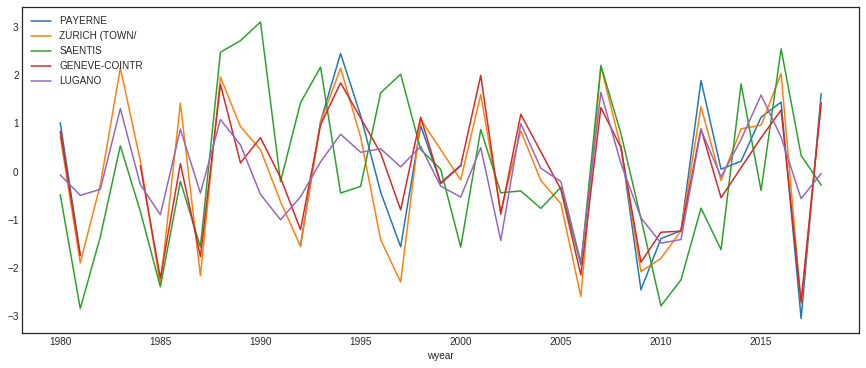

In [26]:
anom_df.plot(x='wyear', figsize=(15,6))

### Create Regression DataFrame

In [27]:
# Create Regression DataFrame
dat_df = pd.merge(anom_df, X_df, on='wyear')
dat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 32 columns):
wyear            38 non-null int64
PAYERNE          21 non-null float64
ZURICH (TOWN/    38 non-null float64
SAENTIS          38 non-null float64
GENEVE-COINTR    36 non-null float64
LUGANO           38 non-null float64
PC1_z70_9        38 non-null float64
PC2_z70_9        38 non-null float64
PC3_z70_9        38 non-null float64
PC1_ci_9         38 non-null float64
PC2_ci_9         38 non-null float64
PC3_ci_9         38 non-null float64
PC1_sst_9        38 non-null float64
PC2_sst_9        38 non-null float64
PC3_sst_9        38 non-null float64
PC1_sstna_9      38 non-null float64
PC2_sstna_9      38 non-null float64
PC3_sstna_9      38 non-null float64
Nino_9           38 non-null float64
PC1_z70_10       38 non-null float64
PC2_z70_10       38 non-null float64
PC3_z70_10       38 non-null float64
PC1_ci_10        38 non-null float64
PC2_ci_10        38 non-null float64
PC3_ci_10  

## Regularization / Lasso Model Selection

#### Generic function for any station :

In [28]:
def predOneStation(target, dat_df):
    # target = 'ZURICH (TOWN/'
    # 'target ~ PC1_ci_10 + PC2_z70_10 + PC3_sst_9' # Wang
    predNames = np.array(['PC1_z70_9',
     'PC2_z70_9',
     'PC3_z70_9',
     'PC1_ci_9',
     'PC2_ci_9',
     'PC3_ci_9',
     'PC1_sst_9',
     'PC2_sst_9',
     'PC3_sst_9', 
     'PC1_z70_10',  
     'PC2_z70_10', 
     'PC3_z70_10',
     'PC1_ci_10', 
     'PC2_ci_10',
     'PC3_ci_10',
     'PC1_sst_10',
     'PC2_sst_10',
     'PC3_sst_10',
     'PC1_sstna_10','PC2_sstna_10','PC3_sstna_10',
                          'Nino_9', 'Nino_10'])
    #ipdb.set_trace()
    dat_df = dat_df[dat_df[target].notnull()] # eliminate NA rows
    X = dat_df[predNames].as_matrix()
    # Target Variables:
    y = dat_df[[target]]
    y = np.ravel(y)
    # Before applying the Lasso, it is necessary to standardize the predictor
    scaler = StandardScaler()
    scaler.fit(X)
    X_stan = scaler.transform(X)
    # In order to find the optimal penalty parameter alpha,
    # use Cross-validated Lasso
    #modlcv = LassoLarsIC(criterion='aic')
    modlcv = LassoCV(cv=3, n_alphas=10000,max_iter=10000)
    modlcv.fit(X_stan, y)
    alpha = modlcv.alpha_

    # Name Of the non-null coefficients:
    # 'target ~ PC1_ci_10 + PC2_z70_10 + PC3_sst_9' # Wang
    ind = np.array(list(map(lambda x: float(x)!=0, modlcv.coef_)))
    importance_df = pd.DataFrame({'pred': predNames[ind], 
                                  'coef': modlcv.coef_[ind]})
    importance_df = importance_df.assign(absCoef=np.absolute(importance_df.coef))
    # According to the Lasso, the 3 strongest predictors are:
    # PC1_ci_10, PC2_z70_10, PC3_z70_9 
    importance_df.sort_values('absCoef', ascending=False)
    res = dict({'R2': modlcv.score(X_stan, y),'alpha': alpha, 'importance_df': importance_df})
    return(res)

z = predOneStation(target='PAYERNE', dat_df=dat_df)
z

{'R2': 0.43020265847113937,
 'alpha': 0.16563819049694059,
 'importance_df':        coef        pred   absCoef
 0 -0.494584   PC1_z70_9  0.494584
 1 -0.131226   PC2_z70_9  0.131226
 2  0.035923   PC3_sst_9  0.035923
 3 -0.003144  PC1_z70_10  0.003144
 4 -0.380257  PC2_z70_10  0.380257
 5 -0.266202      Nino_9  0.266202}

In [29]:
z = map(predOneStation, sta_df.name)

In [30]:
for sta_name in colnames:
    z = predOneStation(target=sta_name, dat_df=dat_df)
    if z['R2'] > 0.4:
        print(sta_name, z)

PAYERNE {'R2': 0.43020265847113937, 'alpha': 0.16563819049694059, 'importance_df':        coef        pred   absCoef
0 -0.494584   PC1_z70_9  0.494584
1 -0.131226   PC2_z70_9  0.131226
2  0.035923   PC3_sst_9  0.035923
3 -0.003144  PC1_z70_10  0.003144
4 -0.380257  PC2_z70_10  0.380257
5 -0.266202      Nino_9  0.266202}


/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



In [31]:
dat_df

    wyear   PAYERNE  ZURICH (TOWN/   SAENTIS  GENEVE-COINTR    LUGANO  \
0    1980  1.012032       0.731538 -0.480128       0.831146 -0.068462   
1    1981 -1.724710      -1.896235 -2.841970      -1.746846 -0.494008   
2    1982       NaN      -0.274008 -1.353812            NaN -0.369555   
3    1983       NaN       2.148219  0.534345            NaN  1.304899   
4    1984       NaN       0.220445 -0.827497       0.119176 -0.270648   
5    1985       NaN      -2.357328 -2.389339      -2.208816 -0.896194   
6    1986       NaN       1.414899 -0.201181       0.163192  0.878259   
7    1987       NaN      -2.162874 -1.563023      -1.764801 -0.447287   
8    1988       NaN       1.959352  2.475135       1.807207  1.077166   
9    1989       NaN       0.931579  2.713293       0.179214  0.551619   
10   1990       NaN       0.453806  3.101451       0.701222 -0.473927   
11   1991       NaN      -0.623968 -0.210391      -0.126770 -0.999474   
12   1992 -1.528867      -1.551741  1.427767      -

In [32]:
colnames

Index(['PAYERNE', 'ZURICH (TOWN/', 'SAENTIS', 'GENEVE-COINTR', 'LUGANO'], dtype='object')